
# Lecture 2 - CNN and transfer learning

In this tutorial we firstly investigate how to implement models based on CNNs in tensorflow/keras and secondly we will se some examples of how to transfer the knowledge between different tasks.
For the following instances we will be using:

- <b> tensroflow/keras </b>
- <b> matplotlib </b>
- <b> numpy </b> 

### Import TensorFlow

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import PIL 
import os

### Download and prepare the dataset


This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. 

The first model building example follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 42s 0us/step


Let's inspect the dataset and show some samples.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


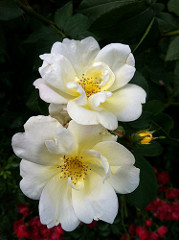

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

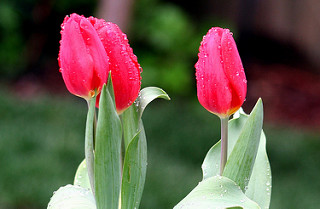

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.
We will divide the images in train and test set.

Some fixed parameters for the dataset loading.

In [6]:
batch_size = 32
d1 = 180
d2 = 180

In [7]:
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(d1, d2),
  batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(d1, d2),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

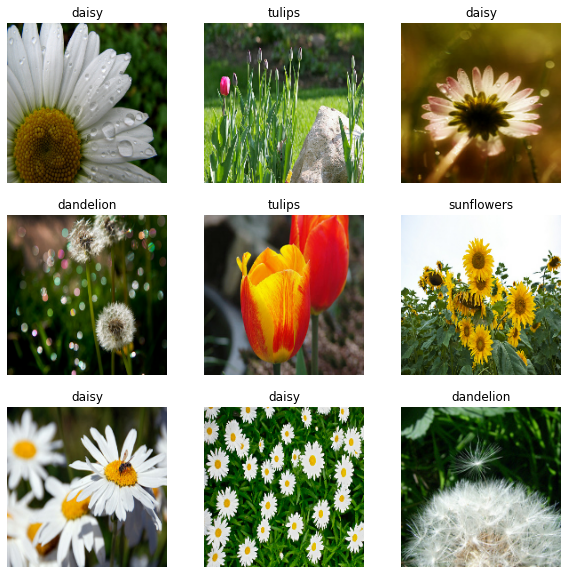

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create the convolutional model

In order to map all the channels of the images in the range [0, 1], we can apply a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize the input.

The lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. 

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.models import Model

def get_model(input_shape):
    x = Input(shape=input_shape)

    r = Rescaling(1./255)(x)

    c1 = Conv2D(16, 3, padding='same', activation='relu')(r)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, 3, padding='same', activation='relu')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, 3, padding='same', activation='relu')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    f = Flatten()(p3)
    d1 = Dense(128, activation='relu')(f)
    d2 = Dense(num_classes)(d1)

    model = Model(x, d2)

    model.summary()
    
    return model

model = get_model((d1, d2, 3))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                         

### Compile the model

Using a last layer with a `softmax` activation and `SparseCategoricalCrossentropy(from_logits = False)` is theoretically equivalent to omit the activation function and set `from_logits = True`. 
This, though, in tensorflow is not always true and it is always better to exploit the `from_logits` parameter, [here](https://stackoverflow.com/questions/61233425/what-should-i-use-as-target-vector-when-i-use-binarycrossentropyfrom-logits-tru/61237426#61237426) you can find some reasons why.

In [11]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

### Train the model

In [12]:
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(train_ds, epochs=10, validation_data = validation_ds)

Epoch 1/10
92/92 [==============================] - 56s 593ms/step - loss: 1.3050 - accuracy: 0.4387 - val_loss: 1.0076 - val_accuracy: 0.5954
Epoch 2/10
92/92 [==============================] - 52s 560ms/step - loss: 0.9354 - accuracy: 0.6322 - val_loss: 1.0374 - val_accuracy: 0.5886
Epoch 3/10
92/92 [==============================] - 52s 560ms/step - loss: 0.7482 - accuracy: 0.7088 - val_loss: 0.9400 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 52s 559ms/step - loss: 0.5617 - accuracy: 0.7939 - val_loss: 1.0427 - val_accuracy: 0.6199
Epoch 5/10
92/92 [==============================] - 52s 564ms/step - loss: 0.3662 - accuracy: 0.8689 - val_loss: 1.2384 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 55s 591ms/step - loss: 0.2143 - accuracy: 0.9278 - val_loss: 1.5336 - val_accuracy: 0.6131
Epoch 7/10
92/92 [==============================] - 55s 590ms/step - loss: 0.1046 - accuracy: 0.9721 - val_loss: 1.6314 - val_accuracy: 0.6417

Let's inspect our results.

In [14]:
# We can also use the history (that we saved before) to check the behavior of the training.
# history is a Python dictionary that cointains the values of the behavior of the loss
# during training (one value for each epoch).
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

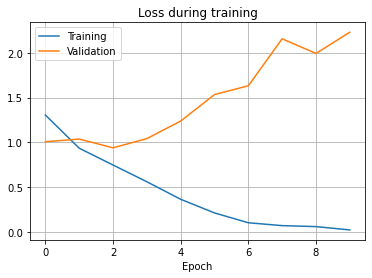

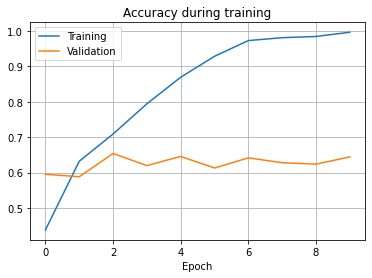

In [15]:
display_history(history)

## Overfitting elimination techniques

In the plots above, the training performances are increasing linearly over time, whereas validation ones are getting worse. Also, the difference in accuracy between training and validation accuracy is a noticeable sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

### Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [17]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = lambda input_shape: tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=input_shape),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

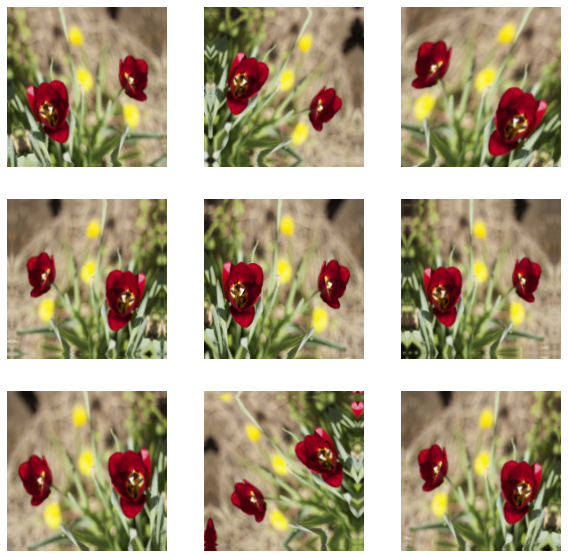

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = (data_augmentation((d1, d2, 3)))(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [19]:
from tensorflow.keras.layers import Dropout

def get_enhanced_model(input_shape):
    x = Input(shape=input_shape)

    augmented = (data_augmentation(input_shape))(x)

    r = Rescaling(1./255)(augmented)

    c1 = Conv2D(16, 3, padding='same', activation='relu')(r)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, 3, padding='same', activation='relu')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, 3, padding='same', activation='relu')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    d = Dropout(.2)(p3)
    f = Flatten()(d)
    d1 = Dense(128, activation='relu')(f)
    d2 = Dense(num_classes)(d1)

    model = Model(x, d2)

    model.summary()
    
    return model

model = get_enhanced_model((d1, d2, 3))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                           

In [20]:
callback = EarlyStopping(monitor="val_accuracy",
    mode = "max",
    min_delta=0.001,
    patience=3,
    restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, epochs=15, validation_data = validation_ds, callbacks = [callback])

Epoch 1/15
92/92 [==============================] - 67s 713ms/step - loss: 1.4338 - accuracy: 0.3910 - val_loss: 1.3205 - val_accuracy: 0.4128
Epoch 2/15
92/92 [==============================] - 67s 720ms/step - loss: 1.1327 - accuracy: 0.5395 - val_loss: 1.0483 - val_accuracy: 0.5790
Epoch 3/15
92/92 [==============================] - 65s 709ms/step - loss: 1.0053 - accuracy: 0.6131 - val_loss: 0.9806 - val_accuracy: 0.5981
Epoch 4/15
92/92 [==============================] - 65s 702ms/step - loss: 0.9314 - accuracy: 0.6362 - val_loss: 0.9509 - val_accuracy: 0.6431
Epoch 5/15
92/92 [==============================] - 65s 701ms/step - loss: 0.8608 - accuracy: 0.6553 - val_loss: 0.8896 - val_accuracy: 0.6717
Epoch 6/15
92/92 [==============================] - 65s 708ms/step - loss: 0.8145 - accuracy: 0.6839 - val_loss: 0.8567 - val_accuracy: 0.6703
Epoch 7/15
92/92 [==============================] - 65s 705ms/step - loss: 0.7776 - accuracy: 0.6948 - val_loss: 0.9194 - val_accuracy: 0.6553

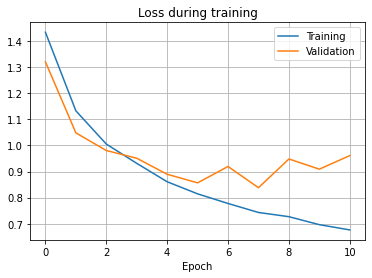

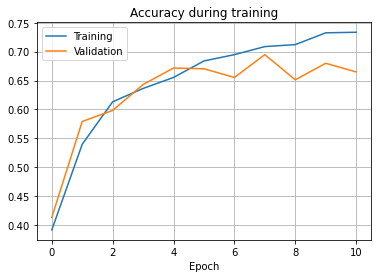

In [21]:
display_history(history)

Let's try our model on images from a different set. 

In [22]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(d1, d2)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 90.42 percent confidence.


## Transfer learning and fine tuning

In this example, we will see how to apply transfer learning and fine-tuning exploiting a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale classification task. You either use the pretrained model as it is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

There are mainly two ways to use a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
You do not need to (re)train the entire model. The base network already contains features that are generically useful for the task. However, the final classification part of the pretrained model is specific to the original classification task and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

## Build the model

We will create the base model from the **MobileNet V2**, developed at Google. This is a pre-trained model on the ImageNet dataset, a large dataset consisting of 14M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify images from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(d1, d2, 3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 2s 0us/step


In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

## Feature extraction
In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [25]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When we set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When we unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

Let's add now the classification head layer

In [27]:
from tensorflow.keras.layers import GlobalAveragePooling2D

def get_t_l_model(input_shape):
  input = tf.keras.Input(shape=input_shape)
  aug = (data_augmentation(input_shape))(input)
  r = Rescaling(1./127.5, offset=-1)(aug)
  m_n = base_model(r, training = False)
  gap = GlobalAveragePooling2D()(m_n)
  d = Dropout(0.2)(gap)
  out = Dense(num_classes)(d)
  model = tf.keras.Model(input, out)
  model.summary()
  return model

model = get_t_l_model((d1, d2, 3))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [28]:
starting_lr = 1e-4
initial_epochs = 10

model.compile(optimizer=Adam(learning_rate=starting_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
92/92 [==============================] - 89s 915ms/step - loss: 1.6041 - accuracy: 0.3573 - val_loss: 1.2215 - val_accuracy: 0.5177
Epoch 2/10
92/92 [==============================] - 84s 909ms/step - loss: 1.1600 - accuracy: 0.5480 - val_loss: 0.9470 - val_accuracy: 0.6431
Epoch 3/10
92/92 [==============================] - 87s 944ms/step - loss: 0.9765 - accuracy: 0.6322 - val_loss: 0.7958 - val_accuracy: 0.7234
Epoch 4/10
92/92 [==============================] - 86s 936ms/step - loss: 0.8366 - accuracy: 0.6931 - val_loss: 0.7061 - val_accuracy: 0.7520
Epoch 5/10
92/92 [==============================] - 86s 932ms/step - loss: 0.7581 - accuracy: 0.7238 - val_loss: 0.6439 - val_accuracy: 0.7834
Epoch 6/10
92/92 [==============================] - 86s 935ms/step - loss: 0.6928 - accuracy: 0.7418 - val_loss: 0.6022 - val_accuracy: 0.7875
Epoch 7/10
92/92 [==============================] - 86s 936ms/step - loss: 0.6371 - accuracy: 0.7640 - val_loss: 0.5656 - val_accuracy: 0.8025

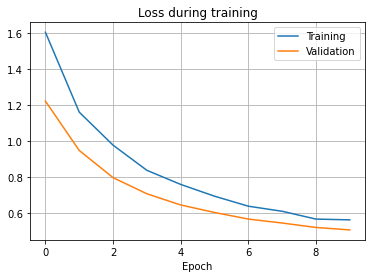

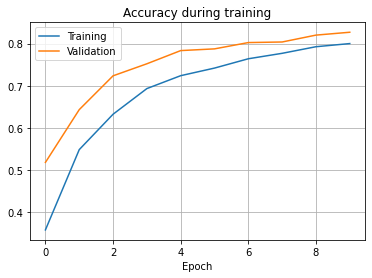

In [29]:
display_history(history)

## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [30]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model 

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=starting_lr/10),
              metrics=['accuracy'])

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 10/20
92/92 [==============================] - 124s 1s/step - loss: 0.4808 - accuracy: 0.8243 - val_loss: 0.3954 - val_accuracy: 0.8624
Epoch 11/20
92/92 [==============================] - 113s 1s/step - loss: 0.3910 - accuracy: 0.8552 - val_loss: 0.3841 - val_accuracy: 0.8719
Epoch 12/20
92/92 [==============================] - 113s 1s/step - loss: 0.3518 - accuracy: 0.8685 - val_loss: 0.3397 - val_accuracy: 0.8842
Epoch 13/20
92/92 [==============================] - 102s 1s/step - loss: 0.2791 - accuracy: 0.8975 - val_loss: 0.3264 - val_accuracy: 0.8856
Epoch 14/20
92/92 [==============================] - 79s 859ms/step - loss: 0.2753 - accuracy: 0.8999 - val_loss: 0.3124 - val_accuracy: 0.8869
Epoch 15/20
92/92 [==============================] - 87s 951ms/step - loss: 0.2455 - accuracy: 0.9149 - val_loss: 0.3178 - val_accuracy: 0.8910
Epoch 16/20
92/92 [==============================] - 71s 769ms/step - loss: 0.2184 - accuracy: 0.9251 - val_loss: 0.3150 - val_accuracy: 0.8896


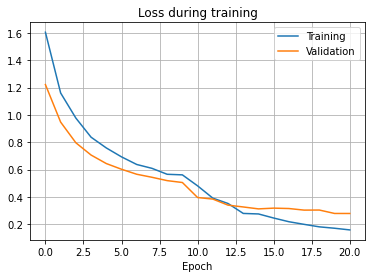

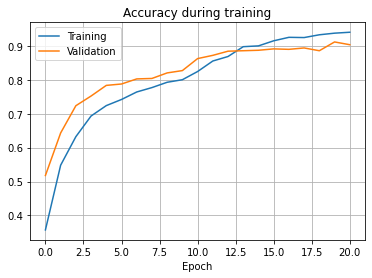

In [33]:
history.history['accuracy'] += history_fine.history['accuracy']
history.history['val_accuracy'] += history_fine.history['val_accuracy']

history.history['loss'] += history_fine.history['loss']
history.history['val_loss'] += history_fine.history['val_loss']

display_history(history)